In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
from os.path import join
from mlsurfacelayer.derived import saturation_mixing_ratio, saturation_vapor_pressure

In [2]:
!which python

/glade/work/dgagne/miniconda3/envs/sfc/bin/python


In [2]:
#cases_path = "/Users/dgagne/data/cases99/"
cases_path = "/glade/p/cisl/aiml/surface_layer/cases99/"
dates = ["991022", "991023", "991024", "991025"]
cases_xr_data = []

for date in dates:
    cases_xr_data.append(xr.open_dataset(join(cases_path, "cases."+ date + ".nc")))
variables = ["T_5m", "T_15m"]
cases_data = pd.concat([x[variables].to_dataframe() for x in cases_xr_data])

In [3]:
def saturation_vapor_pressure(temperature_K):
    """
    Calculate saturation vapor pressure from Clausius-Clapeyron equation in A First Course in
    Atmospheric Thermodynamics by Grant W. Petty

    Args:
        temperature_K: Temperature in Kelvin

    Returns:
        saturation vapor pressure in hPa/q2//q2
    """
    Rv = 461.0
    T0 = 273.0
    es0 = 6.11
    L = 2.5e6
    return es0 * np.exp(L / Rv * (1 / T0 - 1 / temperature_K))


def saturation_mixing_ratio(temperature_K, pressure_hPa):
    """
    Calculate saturation mixing ratio from temperature and pressure

    Args:
        temperature_K: temperature in Kelvin
        pressure_hPa: pressure in hPA

    Returns:
        saturation mixing ratio in g kg-1
    """
    es = saturation_vapor_pressure(temperature_K)
    epsilon = 0.622
    return epsilon * es / (pressure_hPa - es) * 1000.0


In [4]:
t_2m_cases = pd.concat([x["T_2m"].to_dataframe().unstack() for x in cases_xr_data])
rh_2m_cases = pd.concat([x["RH_2m"].to_dataframe().unstack() for x in cases_xr_data])
p_2m_cases = pd.concat([x["P"].to_dataframe().unstack() for x in cases_xr_data])

In [5]:
qv_2m_cases = pd.DataFrame(rh_2m_cases / 100.0 * saturation_mixing_ratio(t_2m_cases.values + 273, p_2m_cases.values))

In [6]:
cases_vars = pd.Series(list(cases_xr_data[0].variables.keys()))
cases_vars[cases_vars.str.contains("T_")]

177     T_5m
186    T_15m
192    T_25m
237    T_35m
364    T_45m
372    T_55m
448     T_2m
dtype: object

# Hello!
this is documentation

In [33]:
nn_wrf = xr.open_dataset("/glade/work/dgagne/WRF-SCM-Ange_casper/WRF-MLSL/test/em_scm_xy/ann_2_ruc_wrfout_d01_1999-10-22_19:00:00")
rf_wrf = xr.open_dataset("/glade/work/dgagne/WRF-SCM-Ange_casper/WRF-MLSL/test/em_scm_xy/rf_2_ruc_wrfout_d01_1999-10-22_19:00:00")
most_wrf = xr.open_dataset("/glade/work/dgagne/WRF-SCM-Ange_casper/WRF-MLSL/test/em_scm_xy/mo_wrfout_d01_1999-10-22_19:00:00")

In [34]:
nn_times = pd.DatetimeIndex(nn_wrf["Times"].astype(str).str.replace("_", "T"))
rf_times = pd.DatetimeIndex(rf_wrf["Times"].astype(str).str.replace("_", "T"))
most_times = pd.DatetimeIndex(most_wrf["Times"].astype(str).str.replace("_", "T"))

In [35]:
pressure = nn_wrf["P"][:, 0, 0, 0] + nn_wrf["PB"][0, 0, 0, 0]


In [36]:
def wrf_temperature(wrf_ds):
    pressure = wrf_ds["P"][1:, 0, 0, 0] + wrf_ds["PB"][1:, 0, 0, 0]
    pot_temp = wrf_ds["T"][1:,0, 0, 0] + 300
    return pot_temp * (pressure / 100000) ** (2.0 / 7.0)

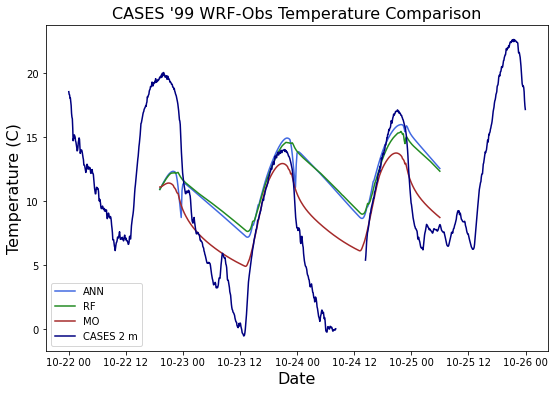

In [37]:
plt.figure(figsize=(9, 6))
plt.plot(nn_times[1:],  wrf_temperature(nn_wrf) - 273, color="royalblue", label="ANN")
plt.plot(rf_times[1:], wrf_temperature(rf_wrf) - 273, color="forestgreen", label="RF")

plt.plot(most_times[1:], wrf_temperature(most_wrf) - 273, color="brown", label="MO")
#plt.plot(cases_data.index, cases_data["T_5m"][:], color="k", label="CASES 5 m")
plt.plot(t_2m_cases.index, t_2m_cases.values.mean(axis=1), color="navy", label="CASES 2 m")
plt.ylabel("Temperature (C)", fontsize=16)
plt.xlabel("Date", fontsize=16)
plt.legend()
plt.title("CASES '99 WRF-Obs Temperature Comparison", fontsize=16)
#plt.xlim("1999-10-22T19:00", "1999-10-25T06:00")
plt.savefig("cases_temp_comp.png", dpi=200, bbox_inches="tight")

In [25]:
nn_wrf.close()
rf_wrf.close()
most_wrf.close()

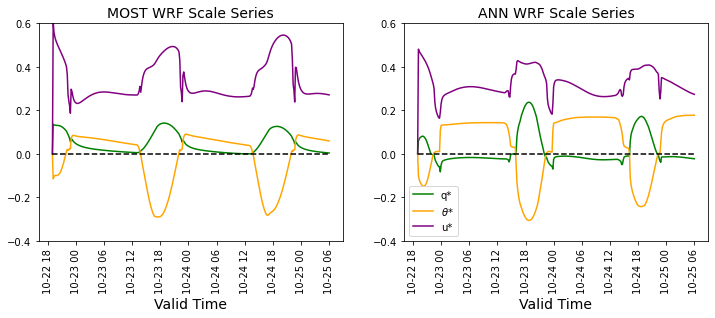

In [38]:
time = pd.DatetimeIndex(pd.Series(most_wrf["Times"][:].values.astype(str)).str.replace("_", "T"))
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(time, most_wrf["QSTAR"][:, 0, 0] * 1000, color="green", label="q*")
plt.plot(time, most_wrf["MOL"][:, 0, 0], color="orange", label="$\\theta$*")
plt.plot(time, most_wrf["UST"][:, 0, 0], color="purple", label="u*")
plt.plot(time, np.zeros(most_wrf["UST"][:, 0, 0].size), 'k--')
plt.xlabel("Valid Time", fontsize=14)
plt.xticks(rotation=90)
plt.title("MOST WRF Scale Series", fontsize=14)
plt.ylim(-0.4, 0.6)
plt.subplot(1, 2, 2)

plt.plot(nn_times, nn_wrf["QSTAR"][:, 0, 0] * 1000, color="green", label="q*")
plt.plot(nn_times, nn_wrf["MOL"][:, 0, 0], color="orange", label="$\\theta$*")
plt.plot(nn_times, nn_wrf["UST"][:, 0, 0], color="purple", label="u*")
plt.plot(nn_times, np.zeros(nn_wrf["UST"][:, 0, 0].size), 'k--')
plt.legend(loc=3)

plt.xlabel("Valid Time", fontsize=14)
plt.title("ANN WRF Scale Series", fontsize=14)
plt.xticks(rotation=90)
plt.ylim(-0.4, 0.6)
plt.savefig("most_ann_scale.png", dpi=200, bbox_inches="tight")

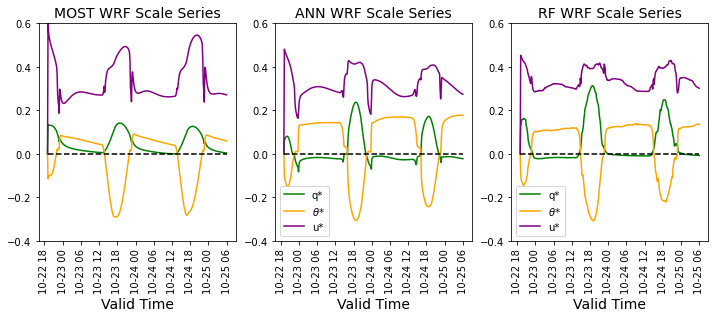

In [39]:
time = pd.DatetimeIndex(pd.Series(nn_wrf["Times"][:].values.astype(str)).str.replace("_", "T"))
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(time, most_wrf["QSTAR"][:, 0, 0] * 1000, color="green", label="q*")
plt.plot(time, most_wrf["MOL"][:, 0, 0], color="orange", label="$\\theta$*")
plt.plot(time, most_wrf["UST"][:, 0, 0], color="purple", label="u*")
plt.plot(time, np.zeros(most_wrf["UST"][:, 0, 0].size), 'k--')
plt.xlabel("Valid Time", fontsize=14)
plt.xticks(rotation=90)
plt.title("MOST WRF Scale Series", fontsize=14)
plt.ylim(-0.4, 0.6)

plt.subplot(1, 3, 2)
plt.plot(time, nn_wrf["QSTAR"][:, 0, 0] * 1000, color="green", label="q*")
plt.plot(time, nn_wrf["MOL"][:, 0, 0], color="orange", label="$\\theta$*")
plt.plot(time, nn_wrf["UST"][:, 0, 0], color="purple", label="u*")
plt.plot(time, np.zeros(nn_wrf["UST"][:, 0, 0].size), 'k--')
plt.legend(loc=3)
plt.xlabel("Valid Time", fontsize=14)
plt.title("ANN WRF Scale Series", fontsize=14)
plt.xticks(rotation=90)
plt.ylim(-0.4, 0.6)

plt.subplot(1, 3, 3)
plt.plot(time, rf_wrf["QSTAR"][:, 0, 0] * 1000, color="green", label="q*")
plt.plot(time, rf_wrf["MOL"][:, 0, 0], color="orange", label="$\\theta$*")
plt.plot(time, rf_wrf["UST"][:, 0, 0], color="purple", label="u*")
plt.plot(time, np.zeros(rf_wrf["UST"][:, 0, 0].size), 'k--')
plt.legend(loc=3)
plt.xlabel("Valid Time", fontsize=14)
plt.title("RF WRF Scale Series", fontsize=14)
plt.xticks(rotation=90)
plt.ylim(-0.4, 0.6)

plt.savefig("most_ann_rf_scale.png", dpi=200, bbox_inches="tight")

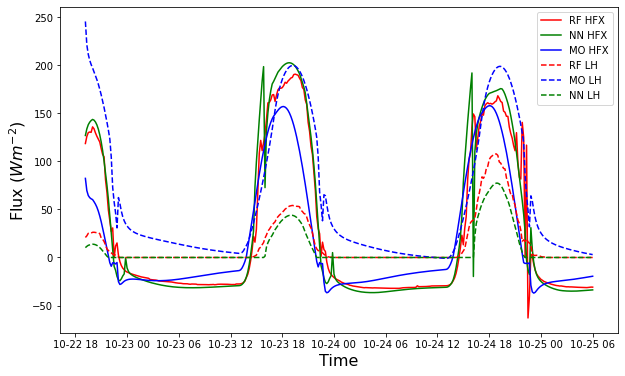

In [30]:
plt.figure(figsize=(10, 6))
plt.plot(rf_wrf["XTIME"][1:], rf_wrf["HFX"][1:, 0, 0], "r-", label="RF HFX")
plt.plot(nn_wrf["XTIME"][1:], nn_wrf["HFX"][1:, 0, 0], "g-", label="NN HFX")

plt.plot(most_wrf["XTIME"][1:], most_wrf["HFX"][1:, 0, 0], "b-", label="MO HFX")
plt.plot(rf_wrf["XTIME"][1:], rf_wrf["LH"][1:, 0, 0], "r--", label="RF LH")
plt.plot(most_wrf["XTIME"][1:], most_wrf["LH"][1:, 0, 0], "b--", label="MO LH")
plt.plot(nn_wrf["XTIME"][1:], nn_wrf["LH"][1:, 0, 0], "g--", label="NN LH")

plt.legend()
#plt.ylim(-100, 400)
plt.xlabel("Time", fontsize=16)
plt.ylabel("Flux ($W m^{-2}$)", fontsize=16)
plt.savefig("wrf_flux_comp_rf17.png", dpi=200, bbox_inches="tight")

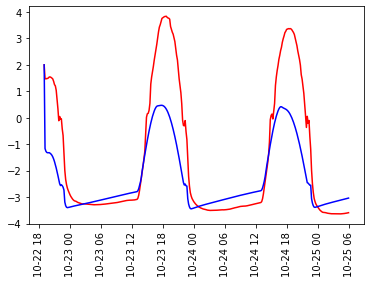

In [15]:
time = pd.DatetimeIndex(pd.Series(rf_wrf["Times"][:].values.astype(str)).str.replace("_", "T"))
plt.plot(time, rf_wrf["TSK"][:, 0, 0] - (rf_wrf["T"][:, 0, 0, 0] + 300), 'r-', label="RF")
plt.plot(time, most_wrf["TSK"][:, 0, 0] - (most_wrf["T"][:, 0, 0, 0] + 300), 'b-', label="MO")
plt.xticks(rotation=90)
plt.savefig("tdiff_comp_rf16.png", dpi=200, bbox_inches="tight")

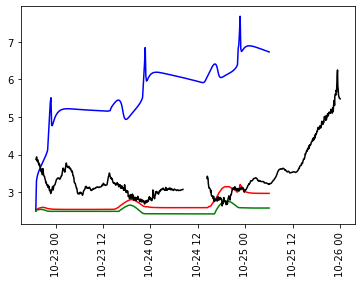

In [31]:
qv_cases_run = qv_2m_cases.loc[cases_data.index >= "1999-10-22-19:00:00"]
qv_cases_run[("RH_2m", b"1")]
time = pd.DatetimeIndex(pd.Series(rf_wrf["Times"][:].values.astype(str)).str.replace("_", "T"))
plt.plot(time, rf_wrf["QVAPOR"][:, 0, 0, 0] * 1000, 'r-', label="RF")
plt.plot(time, most_wrf["QVAPOR"][:, 0, 0, 0] * 1000, 'b-', label="MO")
plt.plot(time, nn_wrf["QVAPOR"][:, 0, 0, 0] * 1000, 'g-', label="NN")
plt.plot(qv_cases_run.index, qv_cases_run[("RH_2m", b"5")], 'k-', label="Cases")
plt.xticks(rotation=90)
plt.savefig("tdiff_comp_rf16.png", dpi=200, bbox_inches="tight")

time
1999-10-22 19:02:30    3.870737
1999-10-22 19:07:30    3.802525
1999-10-22 19:12:30    3.809834
1999-10-22 19:17:30    3.789406
1999-10-22 19:22:30    3.767797
                         ...   
1999-10-25 23:37:30    5.309615
1999-10-25 23:42:30    5.301398
1999-10-25 23:47:30    5.315557
1999-10-25 23:52:30    5.331979
1999-10-25 23:57:30    5.347332
Name: (RH_2m, b'1'), Length: 924, dtype: float32

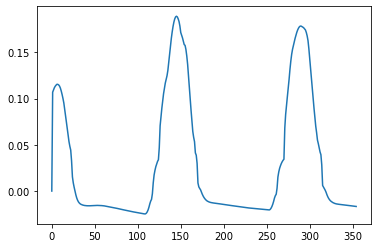

In [69]:
#plt.plot(nn_wrf["FLQC"][:, 0, 0])
plt.plot(nn_wrf["LH"][:, 0, 0])

(119, 355)
(119, 355)
(119, 355)
(59, 355)


/glade/scratch/dgagne/ipykernel_104455/2413170069.py:13: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(pd.DatetimeIndex(rf_wrf["XTIME"].values),
/glade/scratch/dgagne/ipykernel_104455/2413170069.py:23: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(pd.DatetimeIndex(rf_wrf["XTIME"].values),


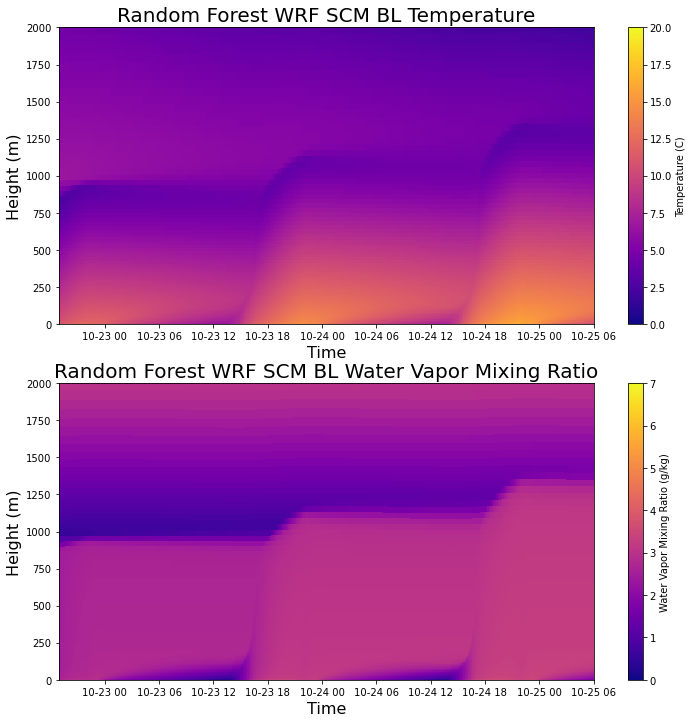

In [17]:
plt.figure(figsize=(12, 12))
pres = (rf_wrf["P"][:, :, 0, 0].T  +rf_wrf["PB"][:, :, 0, 0].T)
height = (rf_wrf["PH"][:, :-1, 0, 0].T + rf_wrf["PHB"][:, :-1, 0, 0].T) / 9.81
temperature = ((rf_wrf["T"][:, :, 0, 0].T + 300) * ( pres/ 100000.0) ** (2. / 7.)) - 273
moisture =rf_wrf["QVAPOR"][:, :, 0, 0].T * 1000
wspd = np.sqrt(rf_wrf["U"][:, :, 0, 0].T ** 2 + rf_wrf["V"][:, :, 0, 0].T ** 2)
print(temperature.shape)
print(wspd.shape)
print(height.shape)
time_tile = np.tile(rf_wrf["XTIME"].values.reshape(-1, 1), 59).T
print(time_tile.shape)
plt.subplot(2, 1, 1)
plt.pcolormesh(pd.DatetimeIndex(rf_wrf["XTIME"].values), 
               height, 
               temperature, vmin=0, vmax=20, cmap="plasma")
plt.ylim(0, 2000)
plt.ylabel("Height (m)", fontsize=16)
plt.xlabel("Time", fontsize=16)
plt.title("Random Forest WRF SCM BL Temperature", fontsize=20)
plt.colorbar(label="Temperature (C)")
plt.subplot(2, 1, 2)

plt.pcolormesh(pd.DatetimeIndex(rf_wrf["XTIME"].values), 
               height, 
               moisture, vmin=0, vmax=7, label="Water Vapor Mixing Ratio", cmap="plasma")
plt.ylim(0, 2000)
plt.ylabel("Height (m)", fontsize=16)
plt.xlabel("Time", fontsize=16)
plt.title("Random Forest WRF SCM BL Water Vapor Mixing Ratio", fontsize=20)
plt.colorbar(label="Water Vapor Mixing Ratio (g/kg)")
plt.savefig("rf_wrf_temp_moisture_2022.png", dpi=200, bbox_inches="tight")

(119, 355)
(119, 355)
(119, 355)
(59, 355)


/glade/scratch/dgagne/ipykernel_104455/3663449839.py:13: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(pd.DatetimeIndex(nn_wrf["XTIME"].values),
/glade/scratch/dgagne/ipykernel_104455/3663449839.py:23: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(pd.DatetimeIndex(nn_wrf["XTIME"].values),


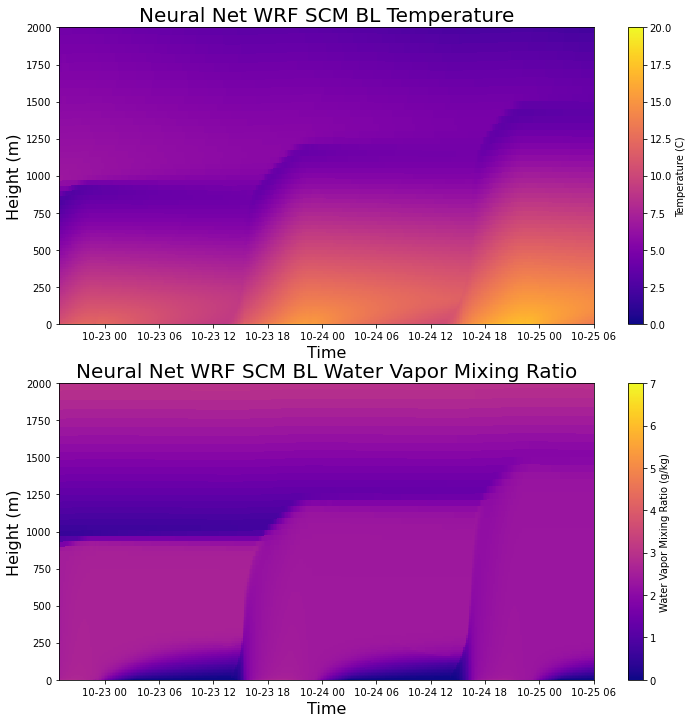

In [18]:
plt.figure(figsize=(12, 12))
pres = (nn_wrf["P"][:, :, 0, 0].T  +nn_wrf["PB"][:, :, 0, 0].T)
height = (nn_wrf["PH"][:, :-1, 0, 0].T + nn_wrf["PHB"][:, :-1, 0, 0].T) / 9.81
temperature = ((nn_wrf["T"][:, :, 0, 0].T + 300) * ( pres/ 100000.0) ** (2. / 7.)) - 273
moisture = nn_wrf["QVAPOR"][:, :, 0, 0].T * 1000
wspd = np.sqrt(nn_wrf["U"][:, :, 0, 0].T ** 2 + nn_wrf["V"][:, :, 0, 0].T ** 2)
print(temperature.shape)
print(wspd.shape)
print(height.shape)
time_tile = np.tile(nn_wrf["XTIME"].values.reshape(-1, 1), 59).T
print(time_tile.shape)
plt.subplot(2, 1, 1)
plt.pcolormesh(pd.DatetimeIndex(nn_wrf["XTIME"].values), 
               height, 
               temperature, vmin=0, vmax=20, cmap="plasma")
plt.ylim(0, 2000)
plt.ylabel("Height (m)", fontsize=16)
plt.xlabel("Time", fontsize=16)
plt.title("Neural Net WRF SCM BL Temperature", fontsize=20)
plt.colorbar(label="Temperature (C)")
plt.subplot(2, 1, 2)

plt.pcolormesh(pd.DatetimeIndex(nn_wrf["XTIME"].values), 
               height, 
               moisture, vmin=0, vmax=7, label="Water Vapor Mixing Ratio", cmap="plasma")
plt.ylim(0, 2000)
plt.ylabel("Height (m)", fontsize=16)
plt.xlabel("Time", fontsize=16)
plt.title("Neural Net WRF SCM BL Water Vapor Mixing Ratio", fontsize=20)
plt.colorbar(label="Water Vapor Mixing Ratio (g/kg)")
plt.savefig("nn_wrf_temp_moisture_2022.png", dpi=200, bbox_inches="tight")

(119, 355)
(119, 355)
(119, 355)
(59, 355)


/glade/scratch/dgagne/ipykernel_104455/3101415094.py:13: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(pd.DatetimeIndex(most_wrf["XTIME"].values),
/glade/scratch/dgagne/ipykernel_104455/3101415094.py:23: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(pd.DatetimeIndex(most_wrf["XTIME"].values),


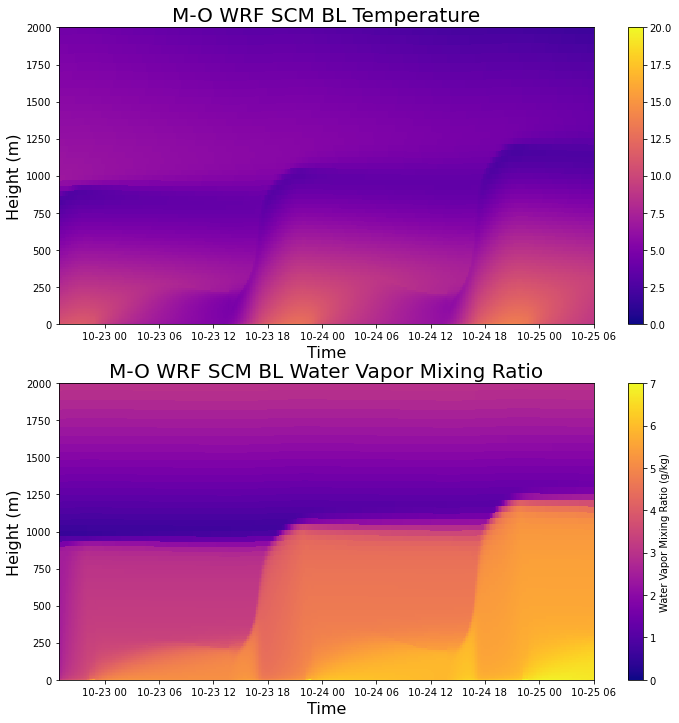

In [19]:
plt.figure(figsize=(12, 12))
pres = (most_wrf["P"][:, :, 0, 0].T  +most_wrf["PB"][:, :, 0, 0].T)
height = (most_wrf["PH"][:, :-1, 0, 0].T + most_wrf["PHB"][:, :-1, 0, 0].T) / 9.81
temperature = ((most_wrf["T"][:, :, 0, 0].T + 300) * ( pres/ 100000.0) ** (2. / 7.)) - 273
moisture = most_wrf["QVAPOR"][:, :, 0, 0].T * 1000
wspd = np.sqrt(most_wrf["U"][:, :, 0, 0].T ** 2 + most_wrf["V"][:, :, 0, 0].T ** 2)
print(temperature.shape)
print(wspd.shape)
print(height.shape)
time_tile = np.tile(most_wrf["XTIME"].values.reshape(-1, 1), 59).T
print(time_tile.shape)
plt.subplot(2, 1, 1)
plt.pcolormesh(pd.DatetimeIndex(most_wrf["XTIME"].values), 
               height, 
               temperature, vmin=0, vmax=20, cmap="plasma")
plt.ylim(0, 2000)
plt.ylabel("Height (m)", fontsize=16)
plt.xlabel("Time", fontsize=16)
plt.title("M-O WRF SCM BL Temperature", fontsize=20)
plt.colorbar()
plt.subplot(2, 1, 2)

plt.pcolormesh(pd.DatetimeIndex(most_wrf["XTIME"].values), 
               height, 
               moisture, vmin=0, vmax=7, label="Water Vapor Mixing Ratio", cmap="plasma")
plt.ylim(0, 2000)
plt.ylabel("Height (m)", fontsize=16)
plt.xlabel("Time", fontsize=16)
plt.title("M-O WRF SCM BL Water Vapor Mixing Ratio", fontsize=20)
plt.colorbar(label="Water Vapor Mixing Ratio (g/kg)")
plt.savefig("most_wrf_temp_moisture.png", dpi=200, bbox_inches="tight")


In [17]:
def saturation_vapor_pressure(temperature_K):
    """
    Calculate saturation vapor pressure from Clausius-Clapeyron equation in A First Course in
    Atmospheric Thermodynamics by Grant W. Petty

    Args:
        temperature_K: Temperature in Kelvin

    Returns:
        saturation vapor pressure in hPa
    """
    Rv = 461.0
    T0 = 273.0
    es0 = 6.11
    L = 2.5e6
    return es0 * np.exp(L / Rv * (1 / T0 - 1 / temperature_K))
def saturation_mixing_ratio(temperature_K, pressure_hPa):
    """
    Calculate saturation mixing ratio from temperature and pressure

    Args:
        temperature_K: temperature in Kelvin
        pressure_hPa: pressure in hPA

    Returns:
        saturation mixing ratio in g kg-1
    """
    es = saturation_vapor_pressure(temperature_K)
    epsilon = 0.622
    return epsilon * es / (pressure_hPa - es) * 1000.0

saturation_mixing_ratio(most_wrf["TSK"][5, 0, 0], most_wrf["PSFC"][5, 0, 0] / 100) / 1000


<xarray.DataArray ()>
array(0.00936107)
Coordinates:
    XLAT     float32 37.6
    XLONG    float32 -96.7
    XTIME    datetime64[ns] 1999-10-22T19:50:00

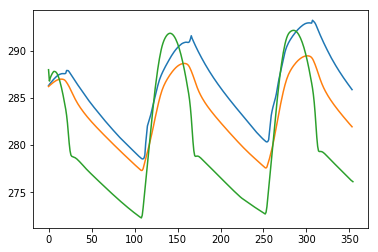

In [12]:
plt.plot(rf_wrf["T"][1:, 0, 0, 0] + 300)
plt.plot(most_wrf["T"][1:, 0, 0, 0] + 300)

#plt.plot(rf_wrf["TH2"][1:,0, 0])
#plt.plot(rf_wrf["T2"][1:, 0, 0])
#plt.plot(rf_wrf["TSK"][0:, 0, 0])
plt.plot(most_wrf["TSK"][0:, 0, 0])


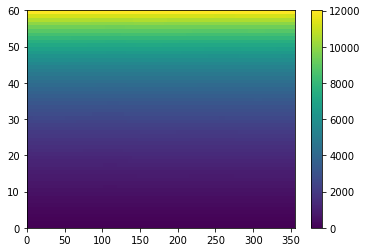

In [6]:
plt.pcolormesh((rf_wrf["PH"][:, :, 0, 0].T + rf_wrf["PHB"][:, :, 0, 0].T) / 9.81)
plt.colorbar()

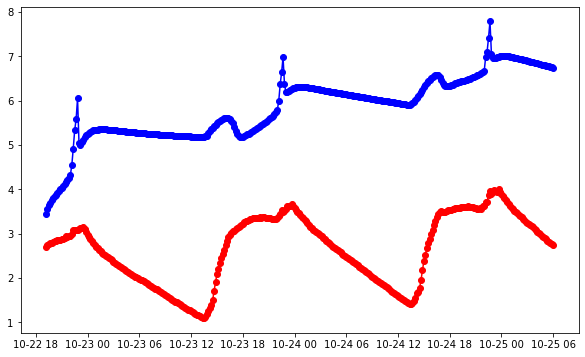

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(pd.DatetimeIndex(rf_wrf["XTIME"].values[1:]), rf_wrf["Q2"][1:, 0, 0] * 1000, 'ro-')
plt.plot(pd.DatetimeIndex(most_wrf["XTIME"].values[1:]), most_wrf["Q2"][1:, 0, 0] * 1000, 'bo-')
plt.plot(

(10886.798611111111, 10889.25)

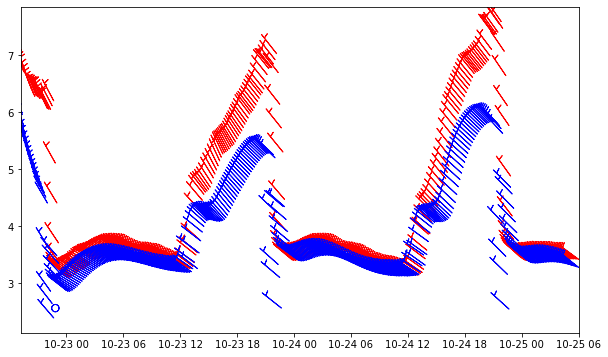

In [62]:
rf_wspd = np.sqrt(rf_wrf["U"][1:, 0, 0, 0] ** 2 + rf_wrf["V"][1:, 0, 0, 0] ** 2)
most_wspd = np.sqrt(most_wrf["U"][1:, 0, 0, 0] ** 2 + most_wrf["V"][1:, 0, 0, 0] ** 2)
times = pd.DatetimeIndex(most_wrf["XTIME"].values[1:])
plt.figure(figsize=(10, 6))
plt.barbs(times, rf_wspd, 
          rf_wrf["U10"][1:, 0, 0], rf_wrf["V10"][1:, 0, 0], color='r')
plt.barbs(times, most_wspd, 
          most_wrf["U10"][1:, 0, 0], most_wrf["V10"][1:, 0, 0], color='b')
plt.xlim(times.min(), times.max())

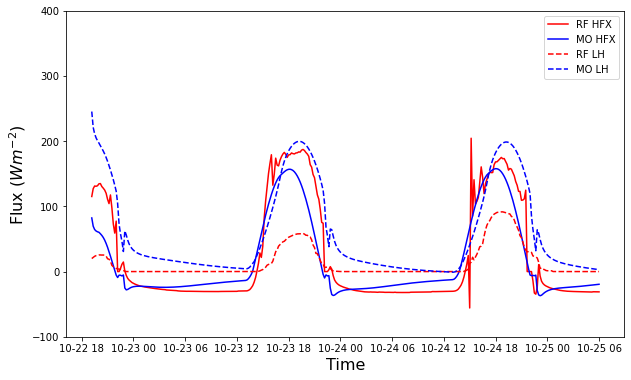

In [32]:
plt.figure(figsize=(10, 6))
plt.plot(rf_wrf["XTIME"][1:], rf_wrf["HFX"][1:, 0, 0], "r-", label="RF HFX")
plt.plot(most_wrf["XTIME"][1:], most_wrf["HFX"][1:, 0, 0], "b-", label="MO HFX")
plt.plot(rf_wrf["XTIME"][1:], rf_wrf["LH"][1:, 0, 0], "r--", label="RF LH")
plt.plot(most_wrf["XTIME"][1:], most_wrf["LH"][1:, 0, 0], "b--", label="MO LH")
plt.legend()
plt.ylim(-100, 400)
plt.xlabel("Time", fontsize=16)
plt.ylabel("Flux ($W m^{-2}$)", fontsize=16)
plt.savefig("wrf_flux_comp.png", dpi=200, bbox_inches="tight")